In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#PDFs in BDT and sindec?
import os

# set env flags to catch BLAS used for scipy/numpy 
# to only use 1 cpu, n_cpus will be totally controlled by csky
os.environ['MKL_NUM_THREADS'] = "1"
os.environ['NUMEXPR_NUM_THREADS'] = "1"
os.environ['OMP_NUM_THREADS'] = "1"
os.environ['OPENBLAS_NUM_THREADS'] = "1"
os.environ['VECLIB_MAXIMUM_THREADS'] = "1"

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['savefig.facecolor'] = 'w'
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import csky as cy
from csky import cext
import numpy as np
import astropy
#from icecube import astro
import histlite as hl
import healpy
import pickle
import socket
healpy.disable_warnings()
plt.rc('figure', facecolor = 'w')
plt.rc('figure', dpi=100)

## Define Settings

In [2]:
selection_version = 'version-001-p00'

host_name = socket.gethostname()

if 'cobalt' in host_name:
    print('Working on Cobalts')
    data_prefix = '/data/user/ssclafani/data/cscd/final'
    ana_dir = '/data/user/ssclafani/data/analyses/'
    plot_dir = '/home/mhuennefeld/public_html/analyses/DNNCascade/plots/review/ps_txs_ngc_test'
    
elif 'phobos' in host_name:
    print('Working on Phobos')
    data_prefix = '/net/big-tank/POOL/users/mhuennefeld/analyses/DNNCascade/data/cscd/final'
    ana_dir = '/net/big-tank/POOL/users/mhuennefeld/analyses/DNNCascade/csky/analyses/'
    plot_dir = '/home/mhuennefeld/analyses/DNNCascade/plots/review/ps_txs_ngc_test'
    
else:
    raise ValueError('Unknown host:', host_name)

Working on Cobalts


In [3]:
for dir_path in [plot_dir]:
    if not os.path.exists(dir_path):
        print('Creating directory:', dir_path)
        os.makedirs(dir_path)

## Load Data

In [4]:
repo = cy.selections.Repository()
specs = cy.selections.DNNCascadeDataSpecs.DNNC_10yr

In [5]:
%%time

ana = cy.get_analysis(
    repo, selection_version, specs, 
    #gammas=np.r_[0.1:6.01:0.125],
)

Setting up Analysis for:
DNNCascade_10yr
Setting up DNNCascade_10yr...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86

In [6]:
a = ana.anas[0]
a.sig

Events(398873 items | columns: azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent, xdec, xra, true_dec, true_energy, true_ra, oneweight)

In [7]:
a.bg_data

Events(59610 items | columns: azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent)

## Setup Analysis

In [8]:
def get_trial_runner(sindec, gamma, cpus, ra=0., cutoff_TeV=np.inf, sigsub=True):
    src = cy.utils.sources(ra, np.arcsin(sindec), deg=False)
    cutoff_GeV = cutoff_TeV * 1e3
    conf = {
        'src' : src, 
        'flux' : cy.hyp.PowerLawFlux(gamma, energy_cutoff = cutoff_GeV),
        'update_bg': True,
        'sigsub' :  sigsub,
        'randomize' : ['ra', cy.inj.DecRandomizer],
        'sindec_bandwidth' : np.radians(5),
        'dec_rand_method' : 'gaussian_fixed',
        'dec_rand_kwargs' : dict(randomization_width = np.radians(3)),
        'dec_rand_pole_exlusion' : np.radians(8)
    }
    tr = cy.get_trial_runner(ana=ana, conf= conf, mp_cpus=cpus)
    return tr, src

def get_bias_allt(tr, ntrials=200, n_sigs=np.r_[:101:10], quiet=False):
    trials = [
        (None if quiet else print(f'\r{n_sig:4d} ...', end='', flush=True))
        or
        tr.get_many_fits(ntrials, n_sig=n_sig, logging=False, seed=n_sig)
        for n_sig in n_sigs]
    if not quiet:
        print()
    for (n_sig, t) in zip(n_sigs, trials):
        t['ntrue'] = np.repeat(n_sig, len(t))
    allt = cy.utils.Arrays.concatenate(trials)
    return allt


## Test Sources

In [9]:
from cycler import cycle

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def get_color_cycler():
    return cycle(colors)


def test_source(
            ra, dec, E2dNdE, E0, unit, gamma, 
            cutoff_TeV=np.inf, sigsub=True, cpus=15, 
            n_bg_trials=100000, 
            n_sig_trials=10000, 
            deg=True
        ):
    
    if deg:
        ra = np.deg2rad(ra)
        dec = np.deg2rad(dec)
    sindec = np.sin(dec)
    
    # get trial runner
    trial_runner, src = get_trial_runner(
        sindec, ra=ra, gamma=gamma, sigsub=sigsub, cpus=cpus, cutoff_TeV=cutoff_TeV)
    
    # compute expected number of events for given flux
    n_expected = trial_runner.to_ns(E2dNdE=E2dNdE, E0=E0, unit=unit) # units are for both E0 and dE 
    print('Number of expected signal events: {}'.format(n_expected))
    
    # get background trials
    print('Performing BG Trials at RA: {}, DEC: {}'.format(src.ra_deg, src.dec_deg))
    bg = cy.dists.Chi2TSD(trial_runner.get_many_fits(n_trials=n_bg_trials, cpus=cpus))
    
    # get signal trials
    print('Performing Signal Trials at RA: {}, DEC: {}'.format(src.ra_deg, src.dec_deg))
    sig_trials = trial_runner.get_many_fits(n_trials=n_sig_trials, cpus=cpus, n_sig=n_expected, poisson=True)
    
    # compute significance
    p_values = bg.sf(sig_trials.ts)
    n_sigma = bg.sf_nsigma(sig_trials.ts)
    
    return sig_trials, bg, p_values, n_sigma, n_expected
        

### Define Sources

In [10]:
source_dict = {
    'NGC 1068': {
        'ra': 40.67,
        'dec': -0.01,
        'gamma': 3.19,
        'E2dNdE': 5e-11,
        'E0': 1,
        'unit': 1000,
    },
    'TXS 0506+056': {
        'ra': 77.36,
        'dec': 5.70,
        'gamma': 2.0,
        'E2dNdE': 0.8e-12,
        'E0': 100,
        'unit': 1000,
    },
    'Cen A [NGC 1068 flux]': {
        'ra': 201.0,
        'dec': -43.5,
        'gamma': 3.19,
        'E2dNdE': 5e-11,
        'E0': 1,
        'unit': 1000,
    },
    'NGC 4945 [NGC 1068 flux]': {
        'ra': 196.3635,
        'dec': -49.4733,
        'gamma': 3.19,
        'E2dNdE': 5e-11,
        'E0': 1,
        'unit': 1000,
    },
    'Cen A [TXS 0506+056 flux]': {
        'ra': 201.0,
        'dec': -43.5,
        'gamma': 2.0,
        'E2dNdE': 0.8e-12,
        'E0': 100,
        'unit': 1000,
    },
    'NGC 4945 [TXS 0506+056 flux]': {
        'ra': 196.3635,
        'dec': -49.4733,
        'gamma': 2.0,
        'E2dNdE': 0.8e-12,
        'E0': 100,
        'unit': 1000,
    },
}
    
    

### Run trials for each source

In [11]:
results = {}
for name, cfg in source_dict.items():
    print('Running trials for: {}'.format(name))
    sig_tr_i, bg_i, p_values_i, n_sigma_i, n_expected_i = test_source(
        ra=cfg['ra'], dec=cfg['dec'], E2dNdE=cfg['E2dNdE'], E0=cfg['E0'], unit=cfg['unit'], gamma=cfg['gamma'],
        cpus=20, n_bg_trials=10000, n_sig_trials=10000,
        sigsub=True,
    )
    print()
    
    # save data
    results[name] = {
        'sig_trials': sig_tr_i,
        'bg_trials': bg_i,
        'p_values': p_values_i,
        'n_sigma': n_sigma_i,
        'n_expected': n_expected_i,
    }

    with open(os.path.join(plot_dir, 'trials.pkl'), 'wb') as f:
        pickle.dump(results, f, protocol=2)

Running trials for: NGC 1068
Number of expected signal events: 33.965821077723106
Performing BG Trials at RA: [40.67], DEC: [-0.01]
Performing 10000 background trials using 25 cores:
      10000/10000 trials complete.   
Performing Signal Trials at RA: [40.67], DEC: [-0.01]
Performing 10000 trials with n_sig = 33.966 (poisson) using 25 cores:
      10000/10000 trials complete.   

Running trials for: TXS 0506+056
Number of expected signal events: 6.026073795661092
Performing BG Trials at RA: [77.36], DEC: [5.7]
Performing 10000 background trials using 25 cores:
      10000/10000 trials complete.   
Performing Signal Trials at RA: [77.36], DEC: [5.7]
Performing 10000 trials with n_sig = 6.026 (poisson) using 25 cores:
      10000/10000 trials complete.   

Running trials for: Cen A [NGC 1068 flux]
Number of expected signal events: 25.13051927312738
Performing BG Trials at RA: [201.], DEC: [-43.5]
Performing 10000 background trials using 25 cores:
      10000/10000 trials complete.   
Pe

In [11]:
with open(os.path.join(plot_dir, 'trials.pkl'), 'rb') as f:
    results = pickle.load(f)


## Make Plots

NGC 1068
883 2601
1226 3179

TXS 0506+056
2666 1281
1161 3296

Cen A [NGC 1068 flux]
1011 2258
1239 3739

NGC 4945 [NGC 1068 flux]
864 2266
1308 3506

Cen A [TXS 0506+056 flux]
2872 1034
1311 3662

NGC 4945 [TXS 0506+056 flux]
2631 1039
1256 3514


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


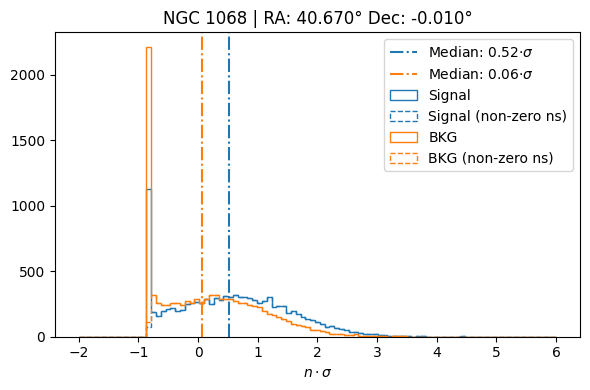

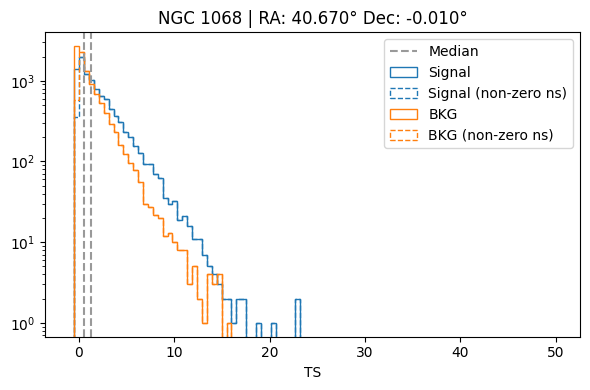

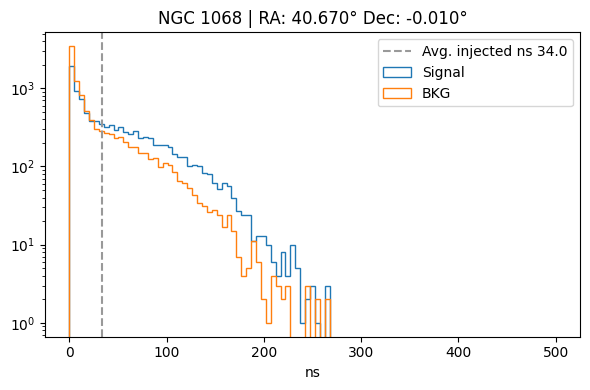

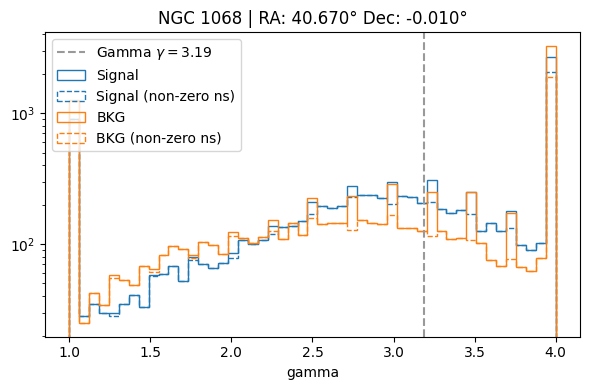

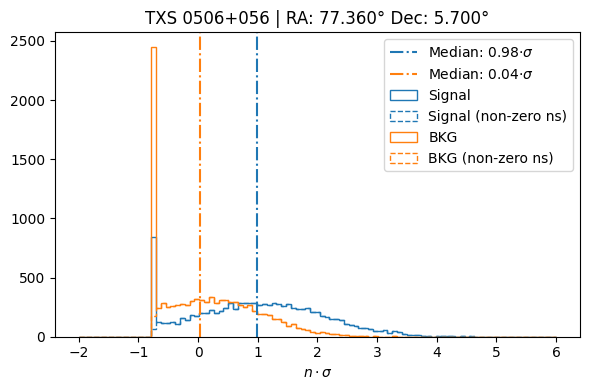

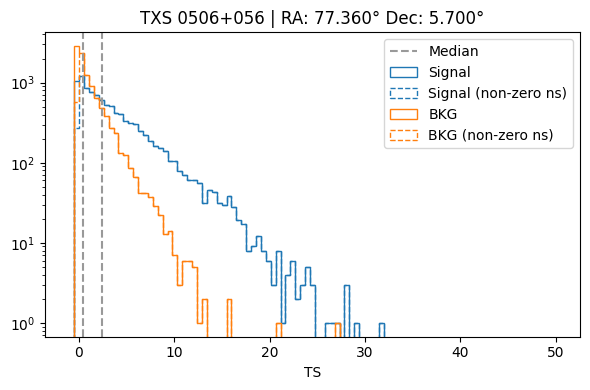

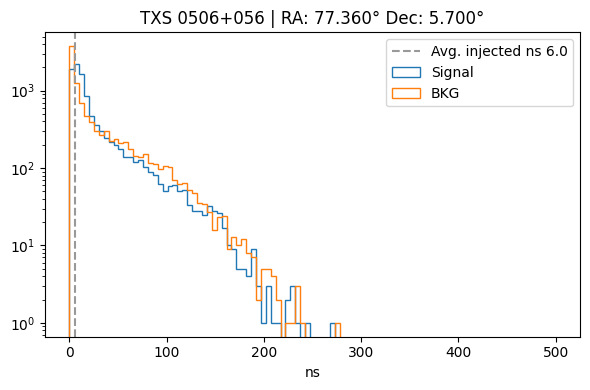

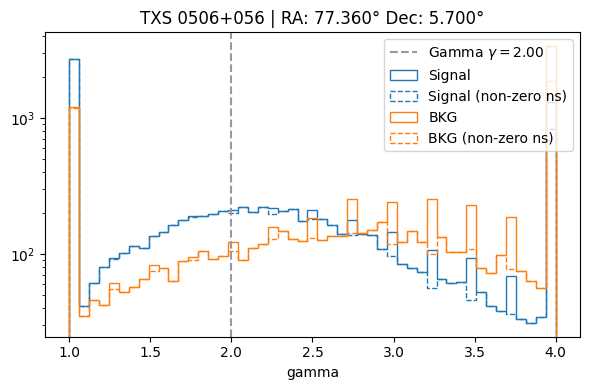

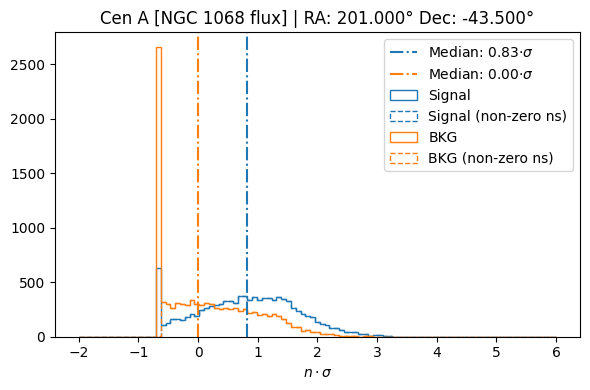

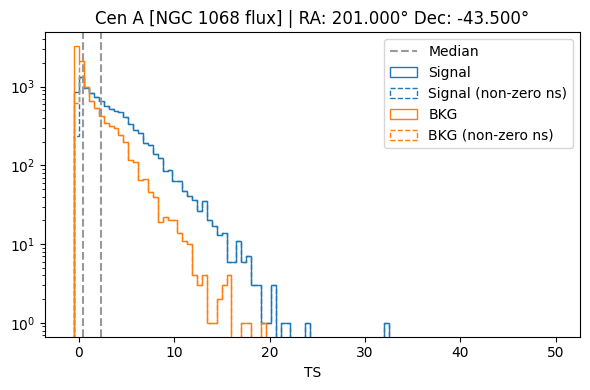

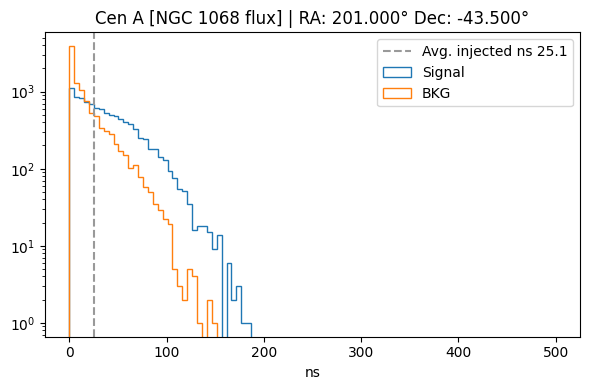

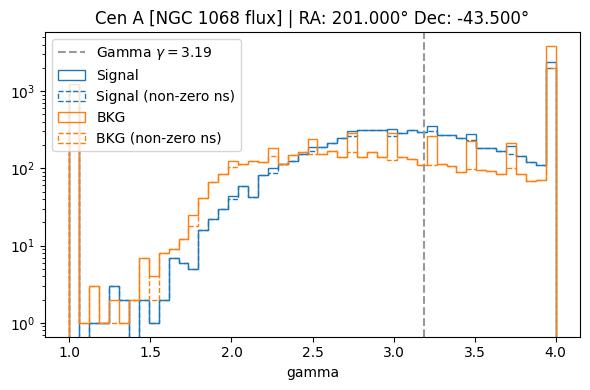

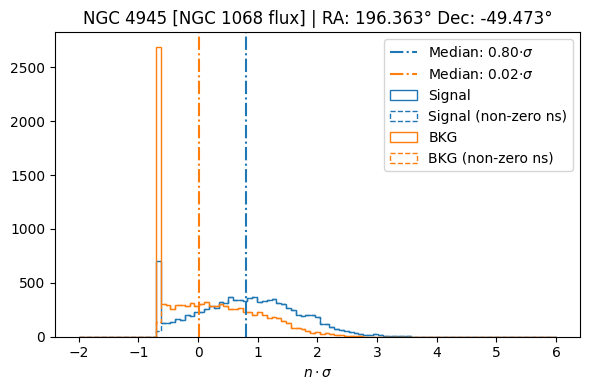

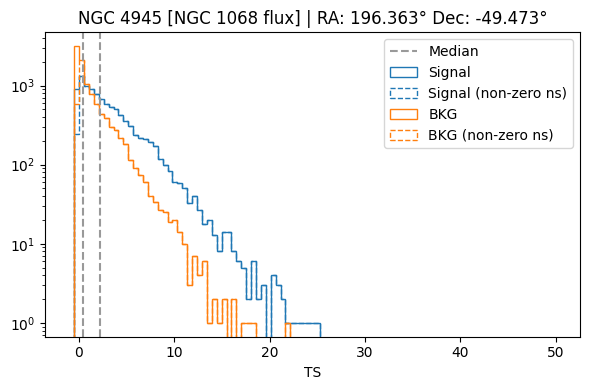

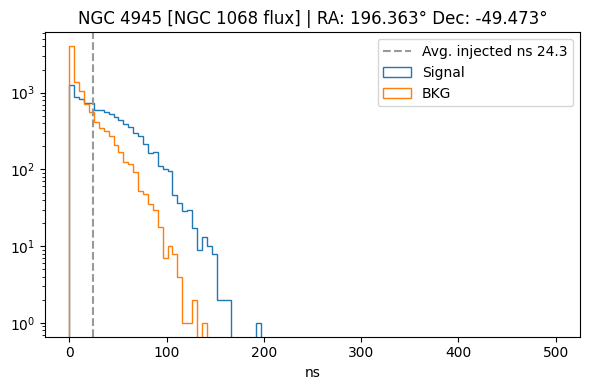

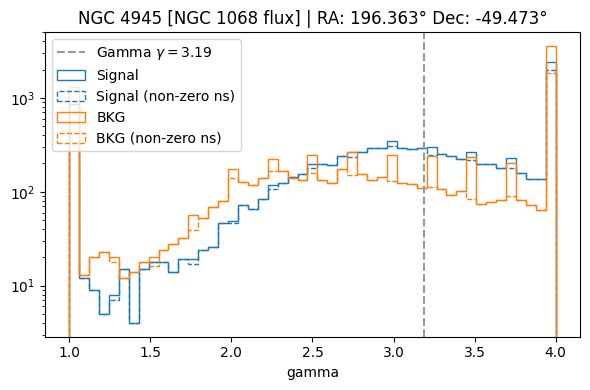

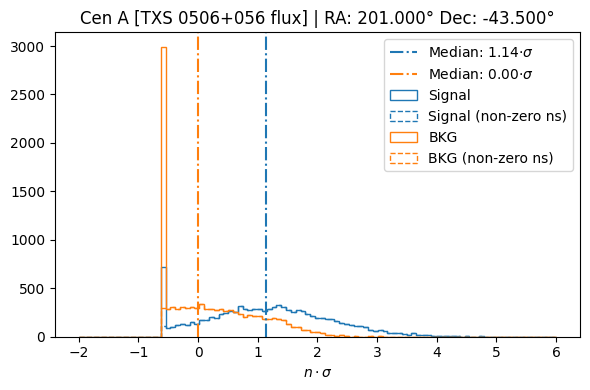

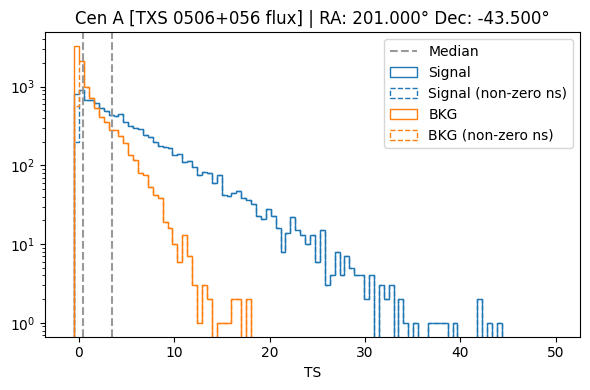

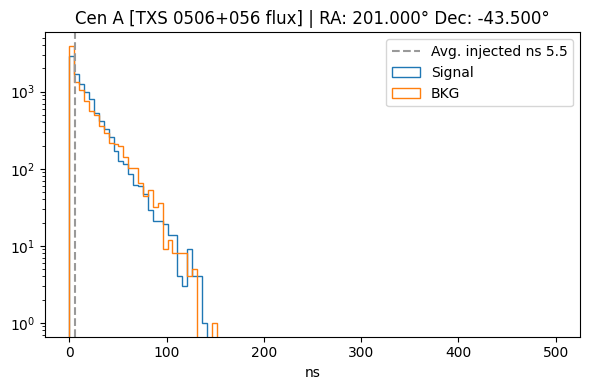

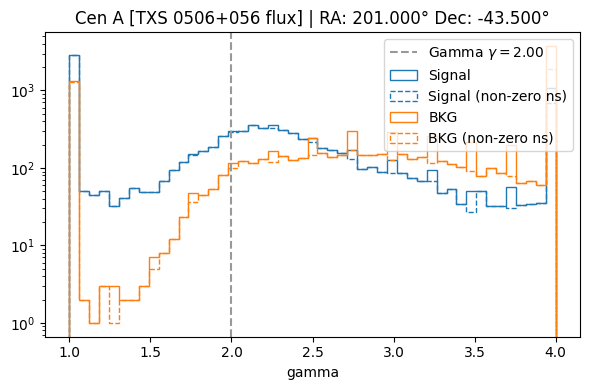

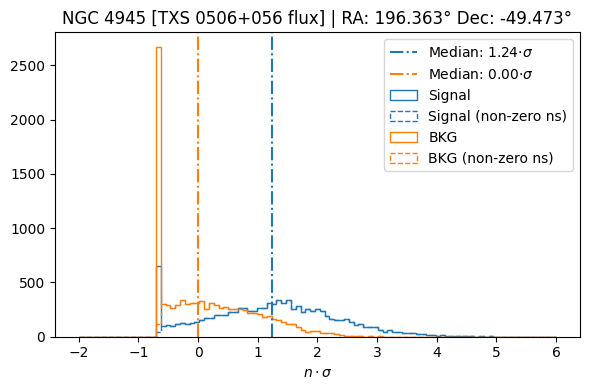

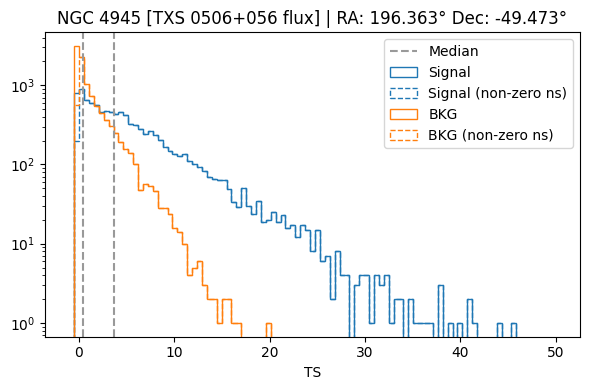

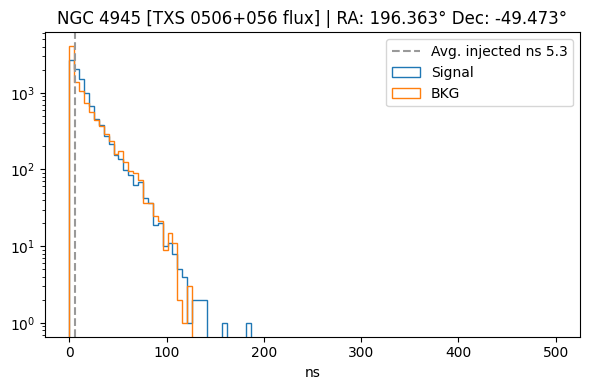

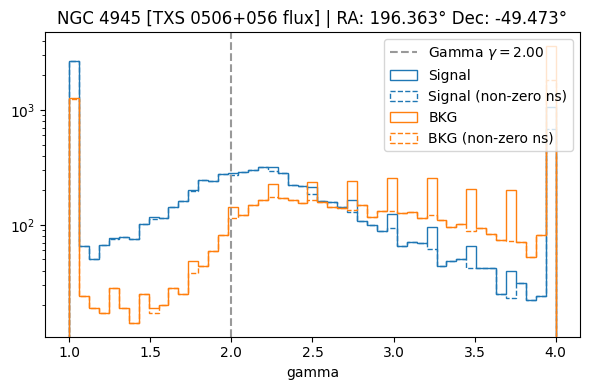

In [15]:

for name, res in results.items():
    print(name)
    print(np.sum(res['sig_trials'].gamma == 1), np.sum(res['sig_trials'].gamma == 4))
    print(np.sum(res['bg_trials'].trials.gamma == 1), np.sum(res['bg_trials'].trials.gamma == 4))
    
    fname = name.replace(' ', '_').replace('[', '_').replace(']', '_').replace('+', '')
    title = r'{} | RA: {:3.3f}° Dec: {:3.3f}°'.format(name, source_dict[name]['ra'], source_dict[name]['dec'])
    
    mask = res['sig_trials'].ns != 0
    mask_bkg = res['bg_trials'].trials.ns != 0
    
    # compute background n-sigma
    bkg_n_sigma = res['bg_trials'].sf_nsigma(res['bg_trials'].trials.ts)
    
    fig, ax = plt.subplots(figsize=(6, 4))
    bins = np.linspace(-2, 6, 100)
    ax.hist(res['n_sigma'], bins=bins, histtype='step', label='Signal', color=colors[0])
    ax.hist(res['n_sigma'][mask], bins=bins, ls='--', histtype='step', label='Signal (non-zero ns)', color=colors[0])
    ax.axvline(np.median(res['n_sigma']), ls='-.', color=colors[0], label='Median: {:3.2f}$\cdot \sigma$'.format(np.median(res['n_sigma'])))
    ax.hist(bkg_n_sigma, bins=bins, histtype='step', label='BKG', color=colors[1])
    ax.hist(bkg_n_sigma[mask_bkg], bins=bins, ls='--', histtype='step', label='BKG (non-zero ns)', color=colors[1])
    ax.axvline(np.median(bkg_n_sigma), ls='-.', color=colors[1], label='Median: {:3.2f}$\cdot \sigma$'.format(np.median(bkg_n_sigma)))
    ax.legend()
    ax.set_xlabel('$n \cdot \sigma$')
    ax.set_title(title)
    #ax.set_xscale('log')
    fig.tight_layout()
    fig.savefig(os.path.join(plot_dir, fname + '_significance.png'))

    fig, ax = plt.subplots(figsize=(6, 4))
    bins = np.linspace(-1, 50, 100)
    ax.hist(res['sig_trials'].ts, bins=bins, histtype='step', label='Signal', color=colors[0])
    ax.hist(res['sig_trials'].ts[mask], bins=bins, ls='--', histtype='step', color=colors[0], label='Signal (non-zero ns)')
    ax.hist(res['bg_trials'].trials.ts, bins=bins, histtype='step', label='BKG', color=colors[1])
    ax.hist(res['bg_trials'].trials.ts[mask_bkg], bins=bins, ls='--', histtype='step', label='BKG (non-zero ns)', color=colors[1])
    ax.axvline(np.median(res['sig_trials'].ts), ls='--', color='0.6', label='Median')
    ax.axvline(np.median(res['bg_trials'].trials.ts), ls='--', color='0.6')
    ax.legend()
    ax.set_xlabel('TS')
    ax.set_yscale('log')
    ax.set_title(title)
    fig.tight_layout()
    fig.savefig(os.path.join(plot_dir, fname + '_ts.png'))

    fig, ax = plt.subplots(figsize=(6, 4))
    bins = np.linspace(0, 500, 100)
    ax.hist(res['sig_trials'].ns, bins=bins, histtype='step', label='Signal', color=colors[0])
    #ax.hist(res['sig_trials'].ns[mask], ls='--', bins=bins, histtype='step', label='Signal (non-zero ns)', color=colors[0])
    ax.hist(res['bg_trials'].trials.ns, bins=bins, histtype='step',label='BKG', color=colors[1])
    ax.set_xlabel('ns')
    ax.set_yscale('log')
    ax.set_title(title)
    ax.axvline(res['n_expected'], ls='--', color='0.6', label='Avg. injected ns {:3.1f}'.format(res['n_expected']))
    ax.legend()
    fig.tight_layout()
    fig.savefig(os.path.join(plot_dir, fname + '_ns.png'))

    fig, ax = plt.subplots(figsize=(6, 4))
    bins = np.linspace(1, 4, 50)
    ax.hist(res['sig_trials'].gamma, bins=bins, histtype='step', label='Signal', color=colors[0])
    ax.hist(res['sig_trials'].gamma[mask], bins=bins, ls='--', histtype='step', label='Signal (non-zero ns)', color=colors[0])
    ax.hist(res['bg_trials'].trials.gamma, bins=bins, histtype='step', label='BKG', color=colors[1])
    ax.hist(res['bg_trials'].trials.gamma[mask_bkg], bins=bins, ls='--', histtype='step', label='BKG (non-zero ns)', color=colors[1])
    ax.axvline(
        source_dict[name]['gamma'], ls='--', color='0.6', 
        label='Gamma $\gamma=${:3.2f}'.format(source_dict[name]['gamma']),
    )
    ax.legend()
    ax.set_xlabel('gamma')
    ax.set_yscale('log')
    ax.set_title(title)
    fig.tight_layout()
    fig.savefig(os.path.join(plot_dir, fname + '_gamma.png'))

    print()